In [1]:
import torch
import numpy as np 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt 
import os 
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torch.autograd as autograd
from torch.autograd import Variable
from PIL import Image
from skimage.color import rgb2gray
from skimage import io
from torchvision.utils import make_grid

In [2]:
#Function to Fetch the Data
def getdata(dir,categories):
    data=[]
    labels=[]
    for c in categories:
            path=os.path.join(dir,c)
            for img in os.listdir(path):
                im_path=os.path.join(path,img)
                image=io.imread(im_path)
                image=rgb2gray(image)
                data.append(image)
                if(c=='horizontal'):
                    labels.append(0)
                else :
                    labels.append(1)
    return data,labels

In [3]:
dir = '/home/sreegs/Documents/CGAN/data'
categories=['horizontal','vertical']


In [4]:
#class to get the Dataset
class train_data(Dataset):
    
    def __init__(self,transform=None):
        self.transform = transform
        
        im_data=[]
        labels=[]

        im_data,labels=getdata(dir,categories)
        
    
    
        im_data = np.asarray(im_data)
        labels = np.asarray(labels)
        labels = labels.reshape((1000,1))
        self.labels = labels
        self.images = im_data

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, int(label)


In [5]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=0.5,std=0.5)])
dataset= train_data(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(2, 2)
        self.model = nn.Sequential(
            nn.Linear(66, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 64)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(2, 2)
        
        self.model = nn.Sequential(
            nn.Linear(102, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 64),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 8, 8)

In [8]:
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
learning_rate=0.0001
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)

In [9]:
#Fucntion to train generator
def train_generator(batch_size,generator,discriminator):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size)))
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [10]:
#Function to train discriminator
def train_discriminator(batch_size,discriminator,generator,real_labels,real_images):
    d_optimizer.zero_grad()
    outputs = discriminator(real_images, real_labels)
    real_loss = criterion(outputs, Variable(torch.ones(batch_size))) 
    z = Variable(torch.randn(batch_size, 100))
    fake_lbels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size)))
    fake_images = generator(z, fake_lbels)
    fake_validity = discriminator(fake_images, fake_lbels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

g_loss: 3.6475272178649902, d_loss: 0.717045783996582


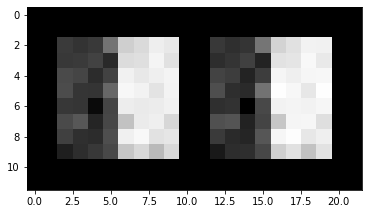

g_loss: 3.4162023067474365, d_loss: 0.6781706213951111


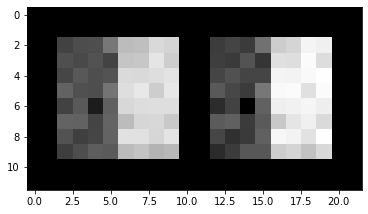

g_loss: 3.642958879470825, d_loss: 0.6571142673492432


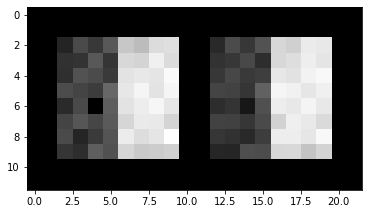

g_loss: 2.769955635070801, d_loss: 0.660342812538147


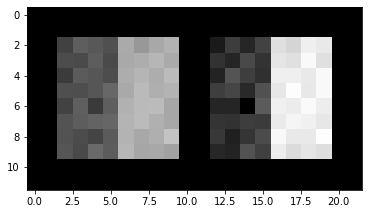

g_loss: 2.87974214553833, d_loss: 0.7131224870681763


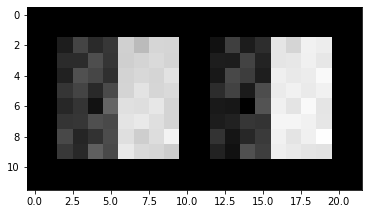

g_loss: 2.3272979259490967, d_loss: 0.7658206820487976


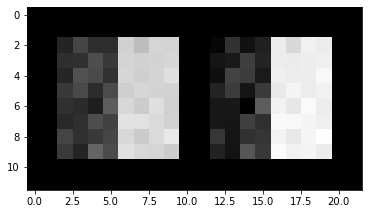

g_loss: 2.959277868270874, d_loss: 0.8228908777236938


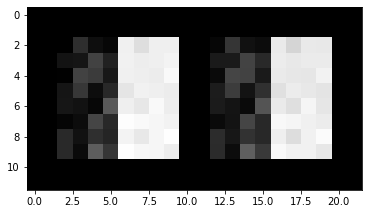

g_loss: 2.8374152183532715, d_loss: 0.7753745317459106


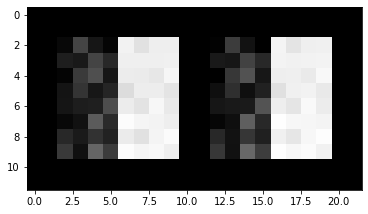

g_loss: 3.59736967086792, d_loss: 0.6714378595352173


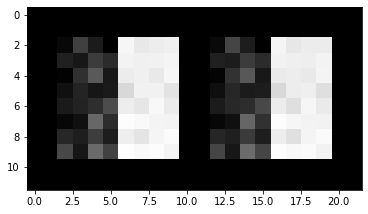

g_loss: 3.4100639820098877, d_loss: 0.780163049697876


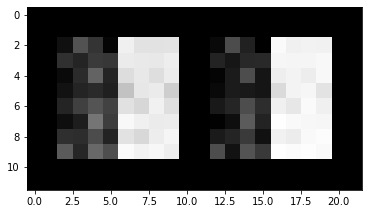

g_loss: 3.477658748626709, d_loss: 0.7108645439147949


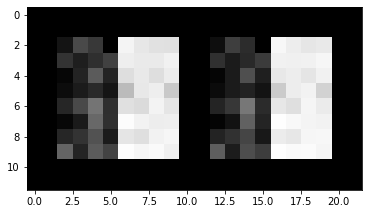

g_loss: 4.860924243927002, d_loss: 0.7385420799255371


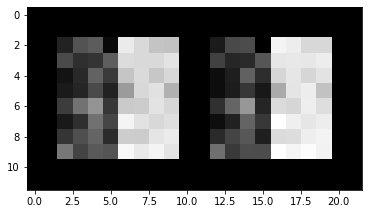

g_loss: 4.914601802825928, d_loss: 0.5357526540756226


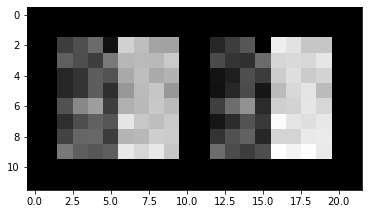

g_loss: 4.2550458908081055, d_loss: 0.6248353123664856


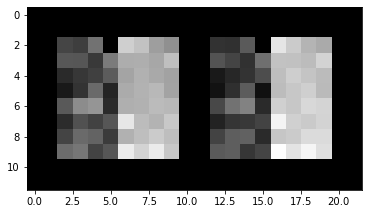

g_loss: 3.582554817199707, d_loss: 0.5080236196517944


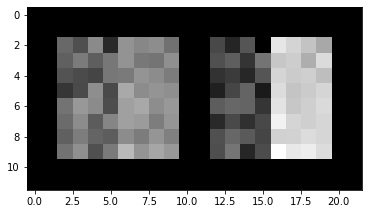

g_loss: 3.203425884246826, d_loss: 0.4984472990036011


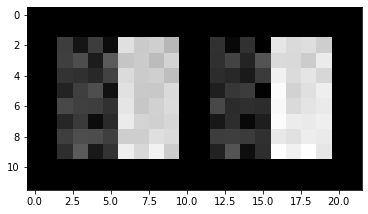

g_loss: 4.585790634155273, d_loss: 0.7284755706787109


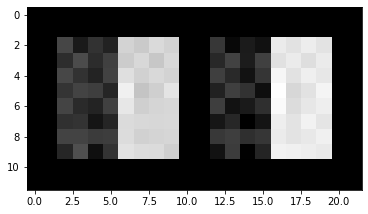

g_loss: 2.66914439201355, d_loss: 0.9387170076370239


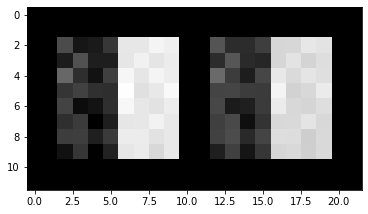

g_loss: 2.5185489654541016, d_loss: 0.9349804520606995


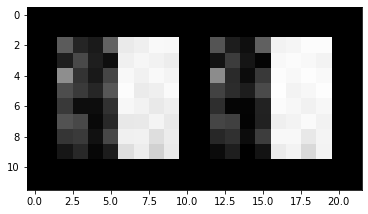

g_loss: 2.9318408966064453, d_loss: 0.805045485496521


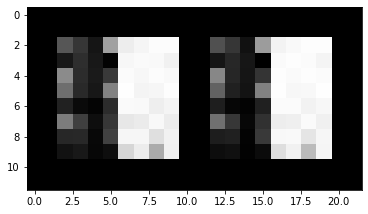

g_loss: 3.8373231887817383, d_loss: 0.6286640167236328


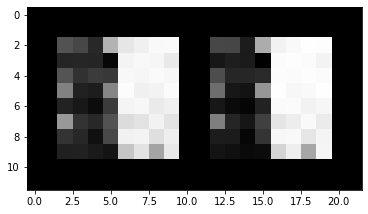

g_loss: 4.415344715118408, d_loss: 0.5526024103164673


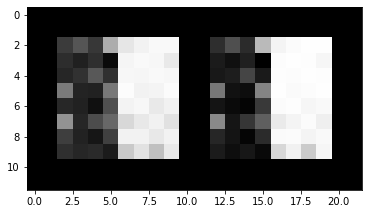

g_loss: 4.439306259155273, d_loss: 0.595774233341217


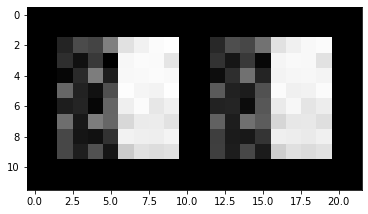

g_loss: 4.994265556335449, d_loss: 0.6744503378868103


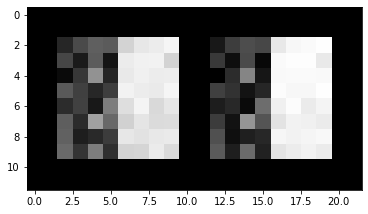

g_loss: 4.806778907775879, d_loss: 0.7556403875350952


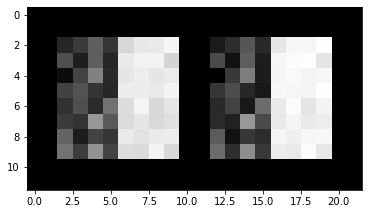

g_loss: 4.427432537078857, d_loss: 0.6284615993499756


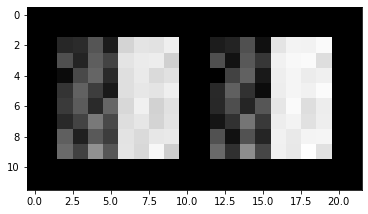

g_loss: 4.054372787475586, d_loss: 0.7040616869926453


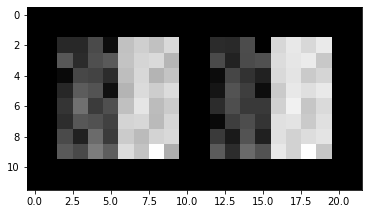

g_loss: 3.3862061500549316, d_loss: 0.6633052825927734


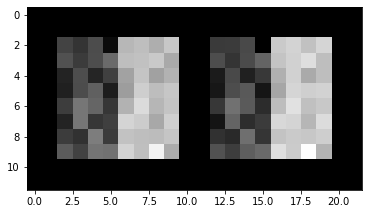

g_loss: 3.0760321617126465, d_loss: 0.6460390686988831


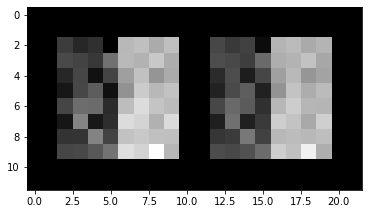

g_loss: 2.918147325515747, d_loss: 0.554025411605835


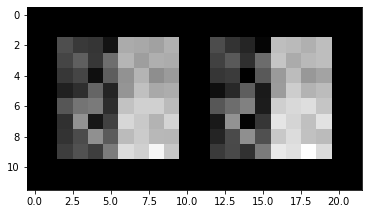

g_loss: 4.05592155456543, d_loss: 0.4032498598098755


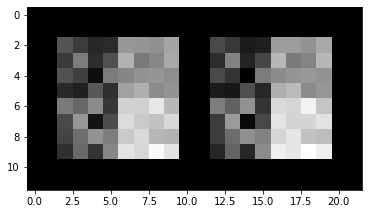

g_loss: 3.396996259689331, d_loss: 1.0630499124526978


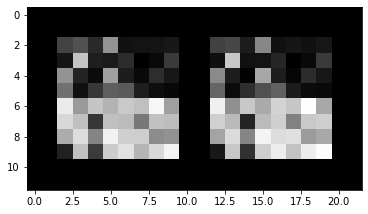

g_loss: 8.362476348876953, d_loss: 0.6092322468757629


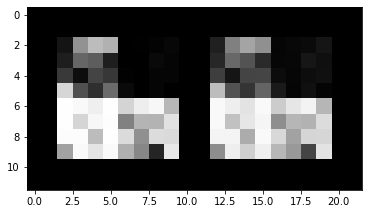

g_loss: 3.6240766048431396, d_loss: 0.9924188852310181


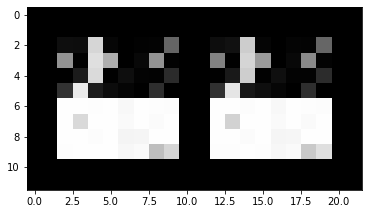

g_loss: 2.5713632106781006, d_loss: 2.6606907844543457


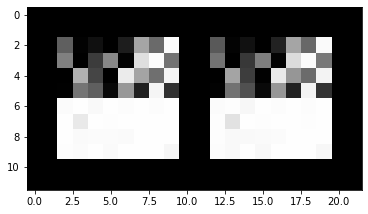

g_loss: 3.4477014541625977, d_loss: 0.6949521899223328


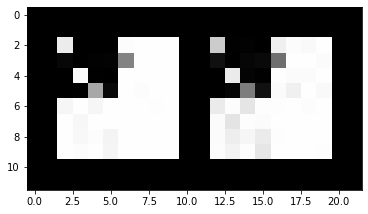

g_loss: 4.296184062957764, d_loss: 0.05965959280729294


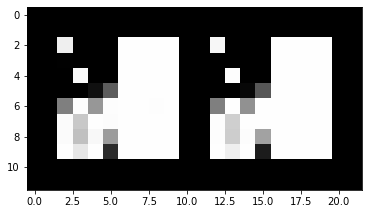

g_loss: 4.411623954772949, d_loss: 0.17539681494235992


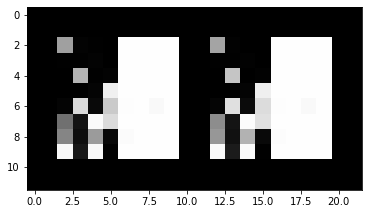

g_loss: 5.545352935791016, d_loss: 0.7106907367706299


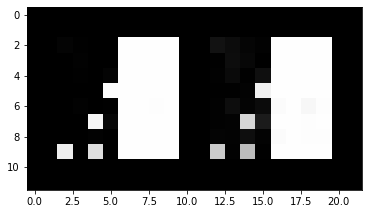

g_loss: 4.594205379486084, d_loss: 0.650346577167511


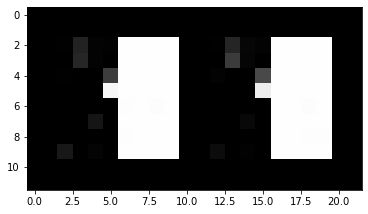

g_loss: 5.0886406898498535, d_loss: 0.5146721601486206


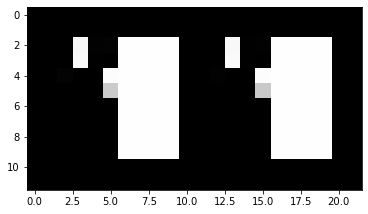

g_loss: 8.805325508117676, d_loss: 0.3061397075653076


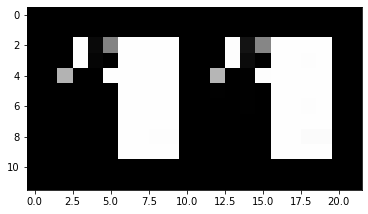

g_loss: 9.616644859313965, d_loss: 0.11877091974020004


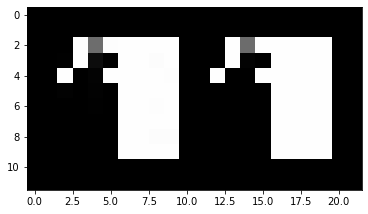

g_loss: 10.952342987060547, d_loss: 0.055791448801755905


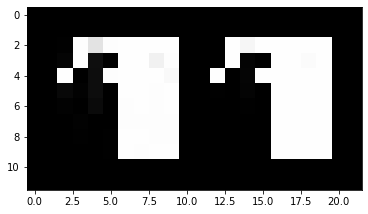

g_loss: 10.452256202697754, d_loss: 0.044647060334682465


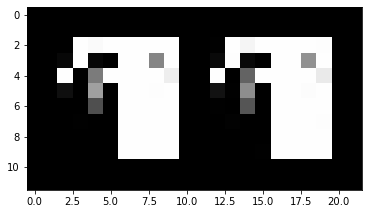

g_loss: 10.92480182647705, d_loss: 0.04106971621513367


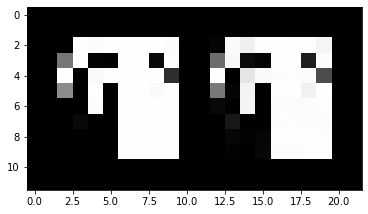

g_loss: 10.08042049407959, d_loss: 0.059784047305583954


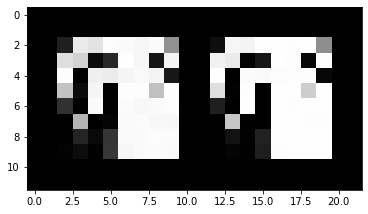

g_loss: 6.929981231689453, d_loss: 0.21340370178222656


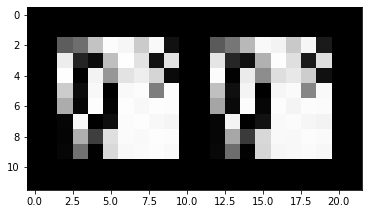

g_loss: 3.6188876628875732, d_loss: 0.2590872049331665


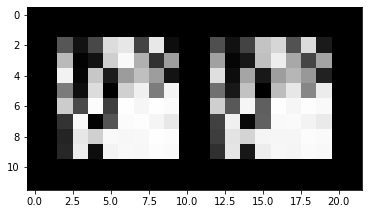

g_loss: 1.5294108390808105, d_loss: 1.2418432235717773


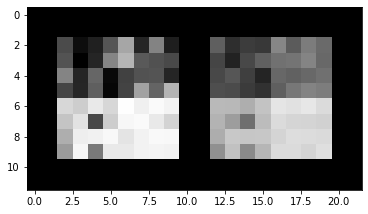

g_loss: 2.3879904747009277, d_loss: 1.3954532146453857


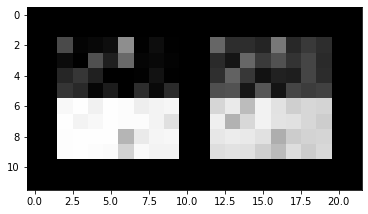

g_loss: 2.355026960372925, d_loss: 1.1074613332748413


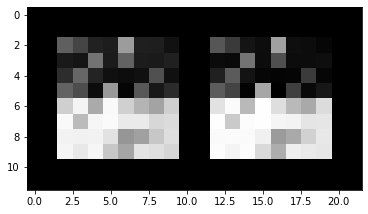

g_loss: 1.9199705123901367, d_loss: 0.8571064472198486


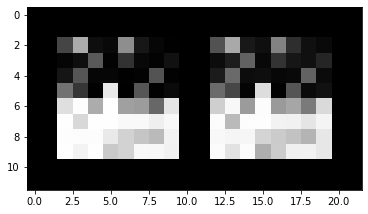

g_loss: 2.7799766063690186, d_loss: 0.6107561588287354


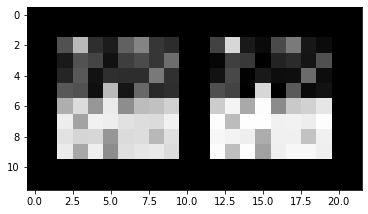

g_loss: 2.3236255645751953, d_loss: 0.6618990898132324


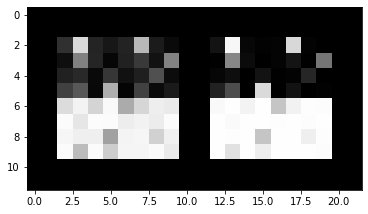

g_loss: 2.705648183822632, d_loss: 0.6666470766067505


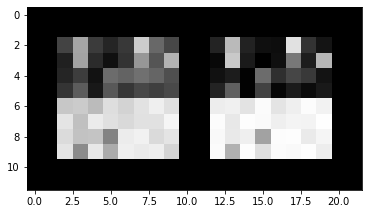

g_loss: 2.139646530151367, d_loss: 0.7984626293182373


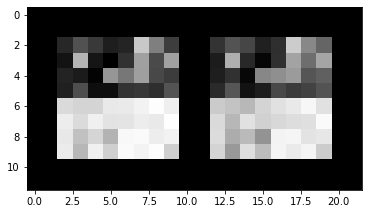

g_loss: 2.4186835289001465, d_loss: 0.6699249744415283


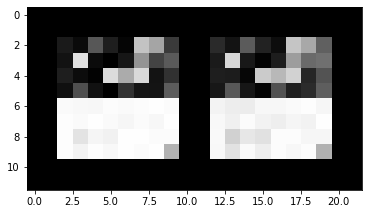

g_loss: 2.7206122875213623, d_loss: 0.547378659248352


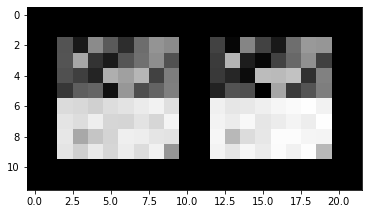

g_loss: 2.0543227195739746, d_loss: 0.7366495132446289


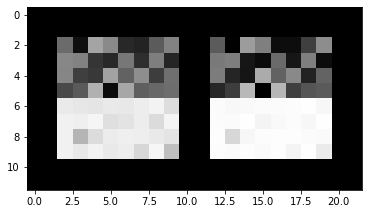

g_loss: 2.4528627395629883, d_loss: 0.829520583152771


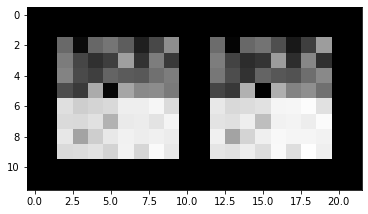

g_loss: 2.639143466949463, d_loss: 0.638441264629364


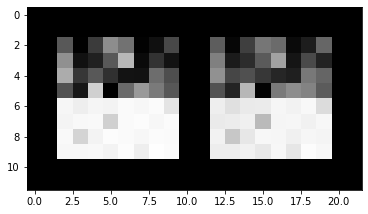

g_loss: 2.979231834411621, d_loss: 0.5772308111190796


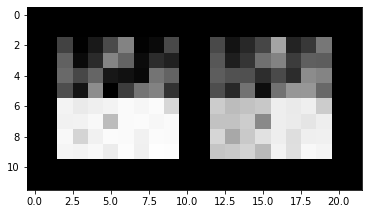

g_loss: 2.8157875537872314, d_loss: 0.653081476688385


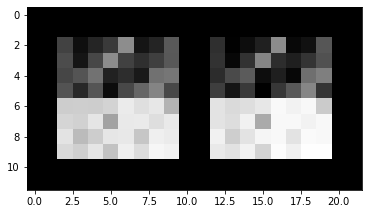

g_loss: 3.9966788291931152, d_loss: 0.5938173532485962


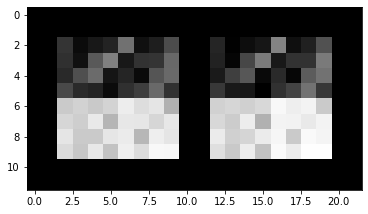

g_loss: 3.828354835510254, d_loss: 0.4697376489639282


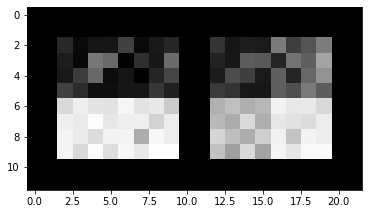

g_loss: 3.405022621154785, d_loss: 0.5602030158042908


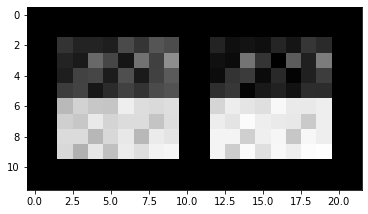

g_loss: 3.0538790225982666, d_loss: 0.6436454057693481


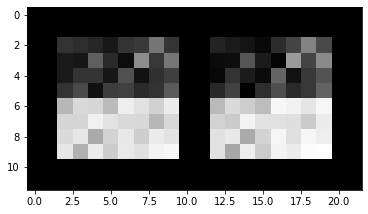

g_loss: 3.0730197429656982, d_loss: 0.7646151781082153


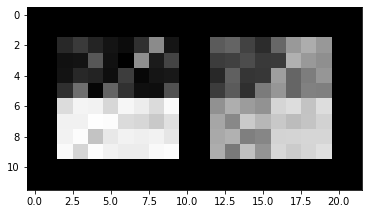

g_loss: 3.2018206119537354, d_loss: 0.6110539436340332


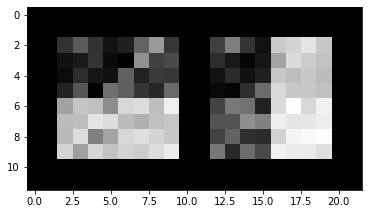

g_loss: 3.0795223712921143, d_loss: 0.5822170376777649


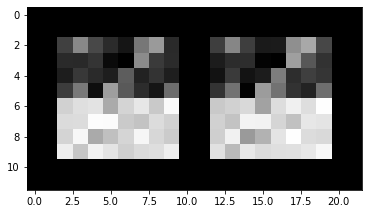

g_loss: 3.1170668601989746, d_loss: 0.4985659718513489


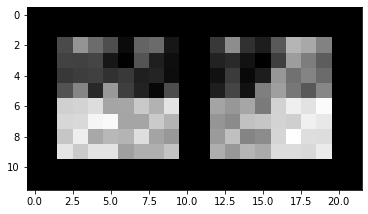

g_loss: 3.050854206085205, d_loss: 0.731158971786499


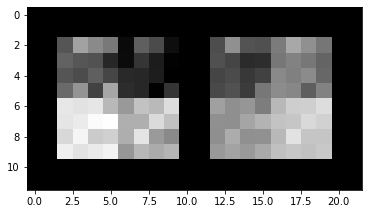

g_loss: 2.7342140674591064, d_loss: 0.790264368057251


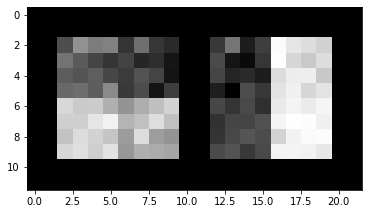

g_loss: 2.1330761909484863, d_loss: 1.0972552299499512


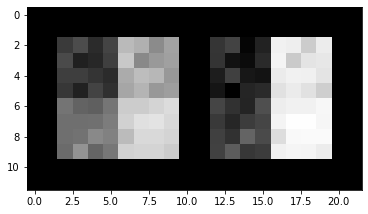

g_loss: 1.1923446655273438, d_loss: 1.5164945125579834


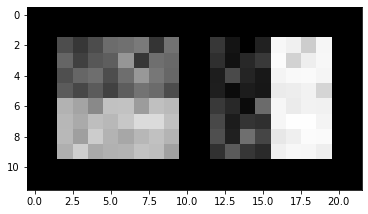

g_loss: 1.1890287399291992, d_loss: 1.428159475326538


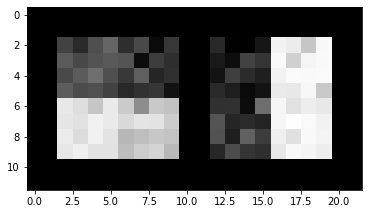

g_loss: 0.9452986717224121, d_loss: 1.5496580600738525


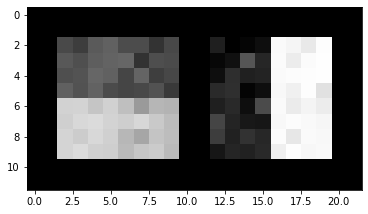

g_loss: 1.1133055686950684, d_loss: 1.6818902492523193


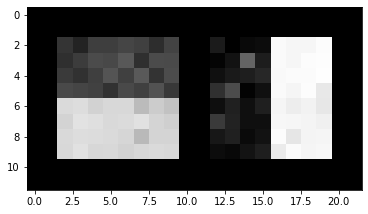

g_loss: 0.7722628116607666, d_loss: 1.6647899150848389


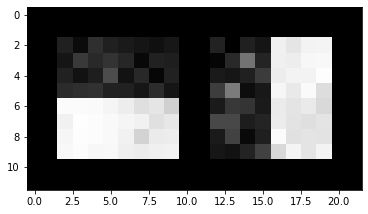

g_loss: 0.8198124170303345, d_loss: 1.534682035446167


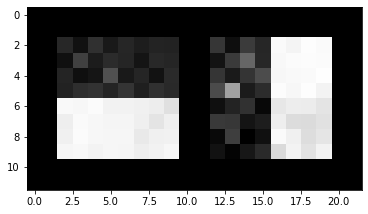

g_loss: 0.8281481862068176, d_loss: 1.5960235595703125


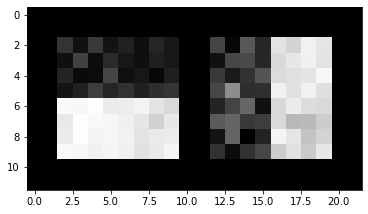

g_loss: 0.787301242351532, d_loss: 1.525880217552185


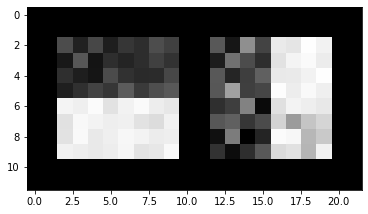

g_loss: 0.8012093901634216, d_loss: 1.4051954746246338


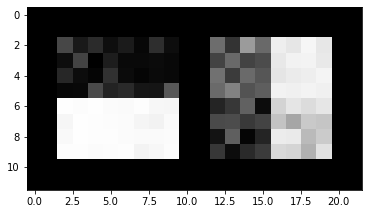

g_loss: 0.8200863003730774, d_loss: 1.3743033409118652


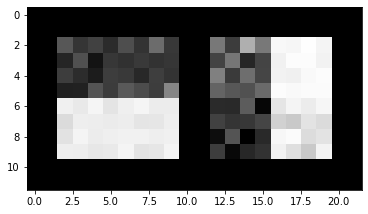

g_loss: 0.784660816192627, d_loss: 1.494143009185791


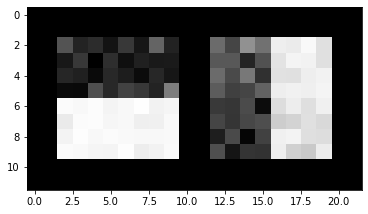

g_loss: 0.7491948008537292, d_loss: 1.4636123180389404


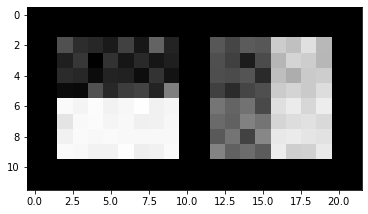

g_loss: 0.7664876580238342, d_loss: 1.489605188369751


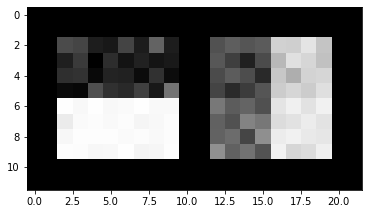

g_loss: 0.7476279735565186, d_loss: 1.395047664642334


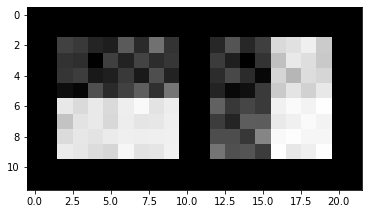

g_loss: 0.757937490940094, d_loss: 1.4047203063964844


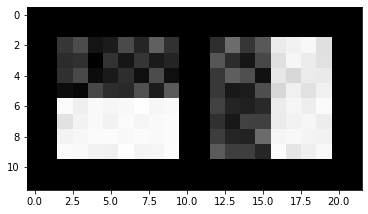

g_loss: 0.747819185256958, d_loss: 1.3383889198303223


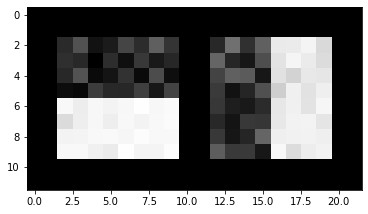

g_loss: 0.7604734897613525, d_loss: 1.3469572067260742


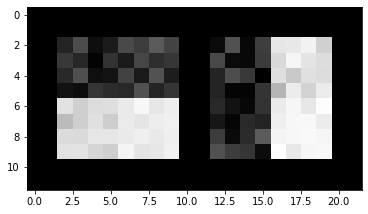

g_loss: 0.8358235955238342, d_loss: 1.344523310661316


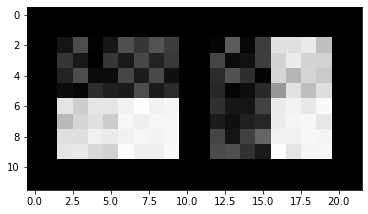

g_loss: 0.7960508465766907, d_loss: 1.3009260892868042


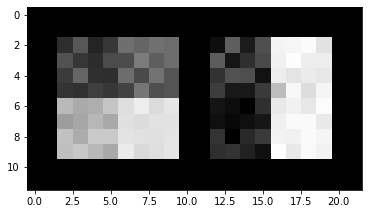

g_loss: 0.7648448348045349, d_loss: 1.3422126770019531


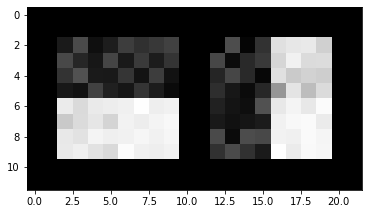

g_loss: 0.7987449169158936, d_loss: 1.3198249340057373


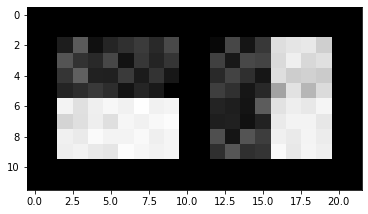

g_loss: 0.7647148370742798, d_loss: 1.3332278728485107


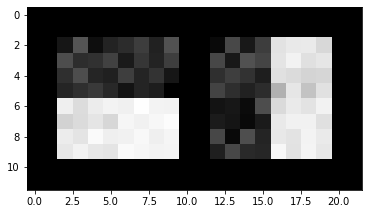

g_loss: 0.7656230330467224, d_loss: 1.2891507148742676


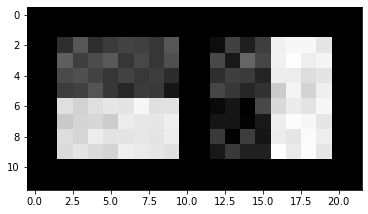

g_loss: 0.8040425181388855, d_loss: 1.3824727535247803


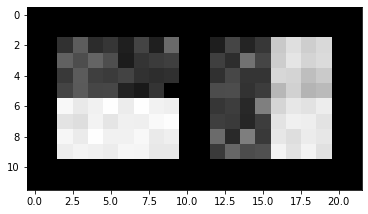

g_loss: 0.7998859882354736, d_loss: 1.327195405960083


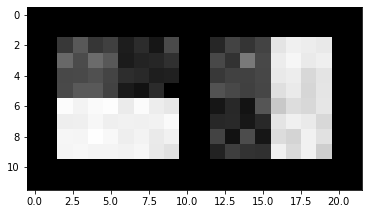

In [15]:
num_epochs=100
#Model Training
for epoch in range(num_epochs):
    for i,(image,label) in enumerate(data_loader):
        generator.train()
        real_img=Variable(image)
        real_label=Variable(label)
        batch_size=real_img.size(0)
        d_loss=train_discriminator(batch_size,discriminator,generator,real_label,real_img)
        g_loss=train_generator(batch_size,generator,discriminator)
        generator.eval()
    
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(2, 100))
    labels = Variable(torch.LongTensor(np.arange(2)))
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()


&lt;matplotlib.image.AxesImage at 0x7fcd324a5810&gt;

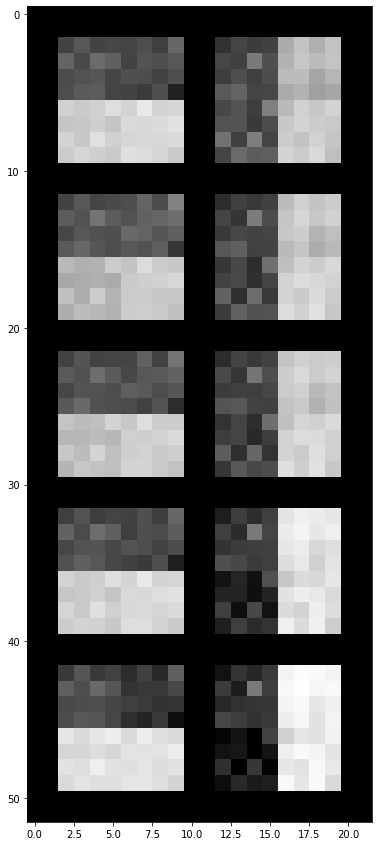

In [16]:
z = Variable(torch.randn(10, 100))
labels = Variable(torch.LongTensor([i for _ in range(5) for i in range(2)]))
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=2, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)